### Import Libraries

In [141]:
import sys
reload(sys)
sys.setdefaultencoding('utf-8')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import *
import seaborn as sns

In [9]:
df_creative = pd.read_table('../data/creatives000',
                       #compression='gzip',
                       sep='|',
                       quotechar='"',
                       error_bad_lines=False,header=None)
df_creative.columns = ['creative_id','created_at','application_id','name','video_id',
                       'is_streaming','language','enforce_language_match','device_type_whitelist',
                      'delivery_frequency_cap','time_to_show_countdown','time_to_show_close_button',
                      'cloudux_template_id']

In [21]:
df_month = pd.read_table('../data/000_sample1.gz',
                       compression='gzip',
                       sep='\t',
                       quotechar='"',
                       error_bad_lines=False)

In [30]:
df_month['is_install'] = df_month['timestamp_at_install'].notnull() * 1
df_month_sub = df_month.loc[:,['is_install','creative_id','time_of_this_impression']]

### Join with other tables

In [31]:
df_mth_ad = pd.merge(df_month_sub, df_creative, how='left', on='creative_id', left_on=None, right_on=None,
         left_index=False, right_index=False, sort=True,
         suffixes=('_x', '_y'), copy=True, indicator=False)

In [32]:
df_mth_ad.head()

,is_install,creative_id,time_of_this_impression,created_at,application_id,name,video_id,is_streaming,language,enforce_language_match,device_type_whitelist,delivery_frequency_cap,time_to_show_countdown,time_to_show_close_button,cloudux_template_id
0,1,50657773219cd8a63f58b1a6,2017-01-27 02:48:20,2012-09-28 10:09:55,505a8244f9bf6d773129ed67,Slots Android,50656548219cd8a63f4d7488,f,en,f,"[""phone"",""tablet""]",0.0,4.0,5.0,NaN
1,0,50657773219cd8a63f58b1a6,2017-01-29 02:21:20,2012-09-28 10:09:55,505a8244f9bf6d773129ed67,Slots Android,50656548219cd8a63f4d7488,f,en,f,"[""phone"",""tablet""]",0.0,4.0,5.0,NaN
2,0,50657773219cd8a63f58b1a6,2017-01-29 22:30:57,2012-09-28 10:09:55,505a8244f9bf6d773129ed67,Slots Android,50656548219cd8a63f4d7488,f,en,f,"[""phone"",""tablet""]",0.0,4.0,5.0,NaN
3,1,50657773219cd8a63f58b1a6,2017-01-29 22:41:27,2012-09-28 10:09:55,505a8244f9bf6d773129ed67,Slots Android,50656548219cd8a63f4d7488,f,en,f,"[""phone"",""tablet""]",0.0,4.0,5.0,NaN
4,0,514352b507bf45fe37000037,2017-01-27 08:37:56,2013-03-15 16:56:21,5113bb72eb600b611500003f,Tap the Frog: Doodle android,514350d6adfd22ff37000027,NaN,en,f,"[""phone"",""tablet""]",0.0,4.0,5.0,NaN


In [50]:
# check NA
df_mth_ad.isnull().sum()

is_install                         0
creative_id                        0
time_of_this_impression            4
created_at                         2
application_id                     2
name                               2
video_id                           2
is_streaming                     157
language                           2
enforce_language_match             2
device_type_whitelist              2
delivery_frequency_cap             2
time_to_show_countdown             2
time_to_show_close_button          2
cloudux_template_id          6960636
dtype: int64

In [62]:
# clean data
df_mth_ad['language'] = df_mth_ad['language'].apply(lambda x: str(x).lower().split('-')[0])
df_mth_ad['is_install'] = df_mth_ad['is_install'].astype('category')

In [195]:
df_mth_ad['delivery_frequency_cap'].unique()

array([      0.,   86400.,  172800.,   43200.,   84600.,      nan])

### Create new features

#### ad age

In [165]:
df_mth_ad['time_delta'] = pd.to_datetime(df_mth_ad['time_of_this_impression'])-pd.to_datetime(df_mth_ad['created_at'])

In [182]:
def to_day(x):
    if isinstance(x,pd.tslib.Timedelta):
        return x.days
    else:
        return np.nan

In [183]:
df_mth_ad['time_delta_days'] = df_mth_ad['time_delta'].apply(to_day)

In [184]:
#df_mth_ad['time_delta_days'].unique()

### Continous Variables

In [201]:
# continous_EDA function
def continous_EDA(col,df):
    print '-----------Feature:', col,'----------------'
    group0 = df[df['is_install']==0][col].dropna()
    group1 = df[df['is_install']==1][col].dropna()
    
    # T-test
    print 't-test'
    print ttest_ind(group0, group1, axis=0, equal_var=False)

    # histogram of two groups
    print 'Distribution of two groups'
    fig, ax = plt.subplots()
    i = 0
    for a in [group0, group1]:
        sns.distplot(a, ax=ax, kde=False,label=str(i))
        i += 1
    ax.legend(loc=2,prop={'size':7})
    plt.show()
    
    # Box-plot
    print 'Box-plot'
    ax = sns.boxplot(x="is_install", y=col, data=df)
    plt.show()
    
    print '---------------------------------\n'

In [202]:
cont_cols = ['time_delta_days']

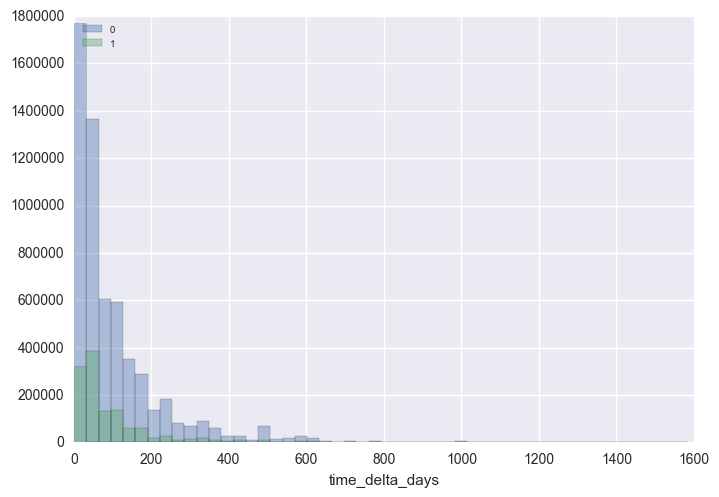

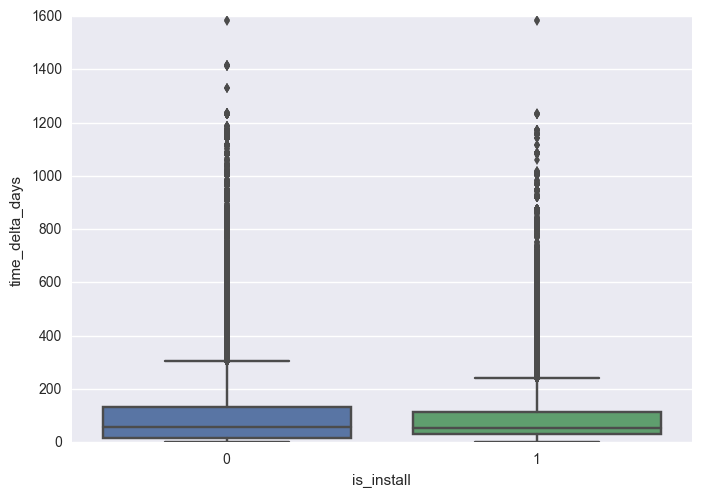

In [203]:
for col in cont_cols:
    continous_EDA(col,df_mth_ad)

### Categorical Variables

In [234]:
cat_cols = ['is_streaming','language','enforce_language_match','device_type_whitelist',
            'delivery_frequency_cap','time_to_show_countdown','time_to_show_close_button',
            'cloudux_template_id']

In [274]:
def categotical_EDA(col, df):
    count = pd.crosstab(df['is_install'],df[col])
    count = count.iloc[:,0:]
    pcts = count.div(count.sum(1).astype(float),axis=0)
    g, p, dof, expctd = chi2_contingency(pcts.as_matrix())
    
    ax = pcts.plot(kind='barh',stacked=True, alpha=0.5, figsize=(8,6))
    ax.set_xlabel("Percentage", fontsize=12)
    ax.set_ylabel("Is Install", fontsize=12)
    ax.legend(loc=2,prop={'size':7})
    
    plt.show()
    return p

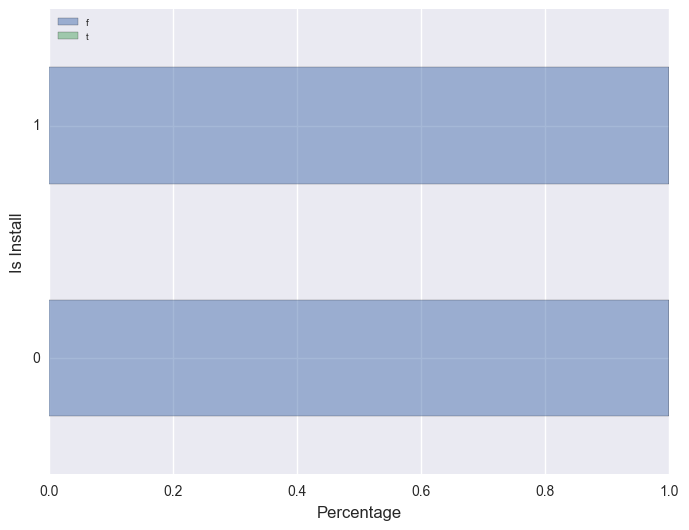

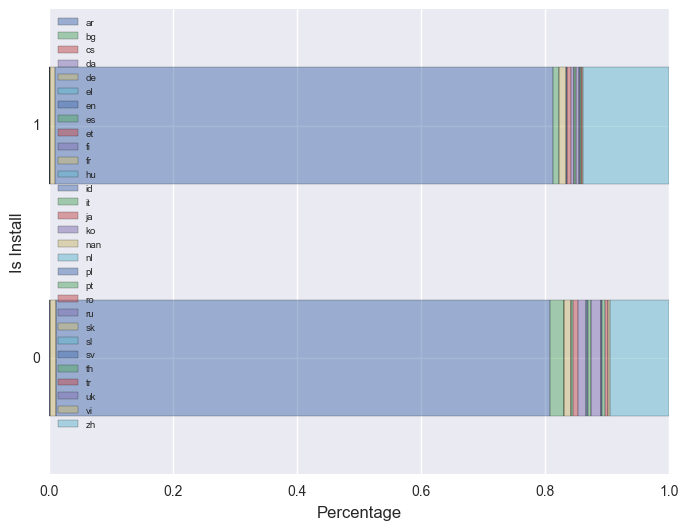

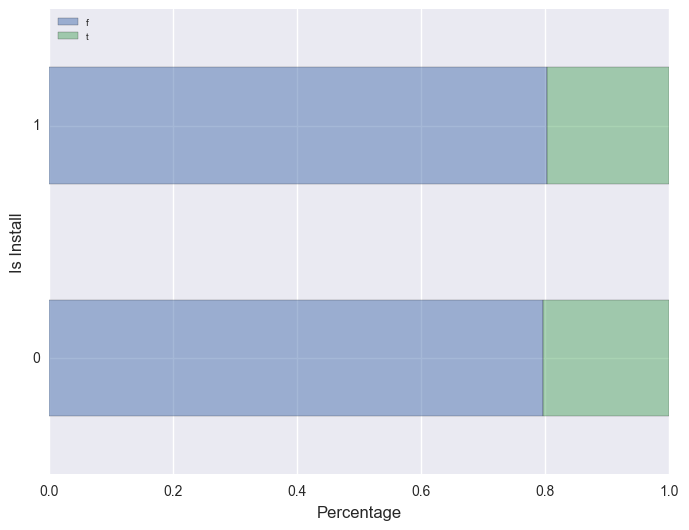

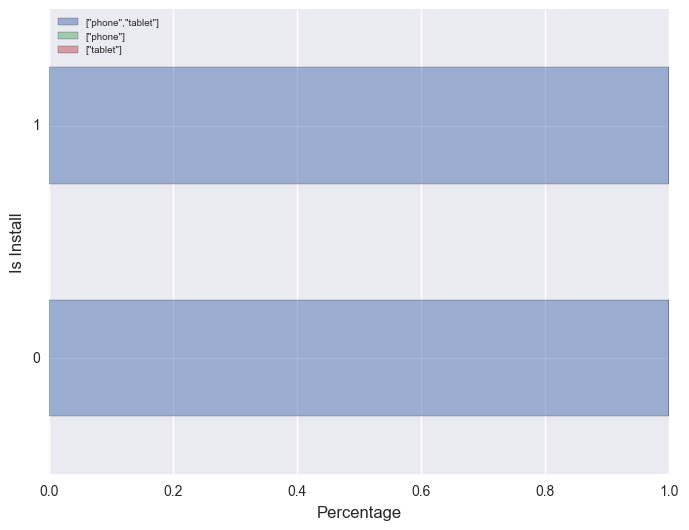

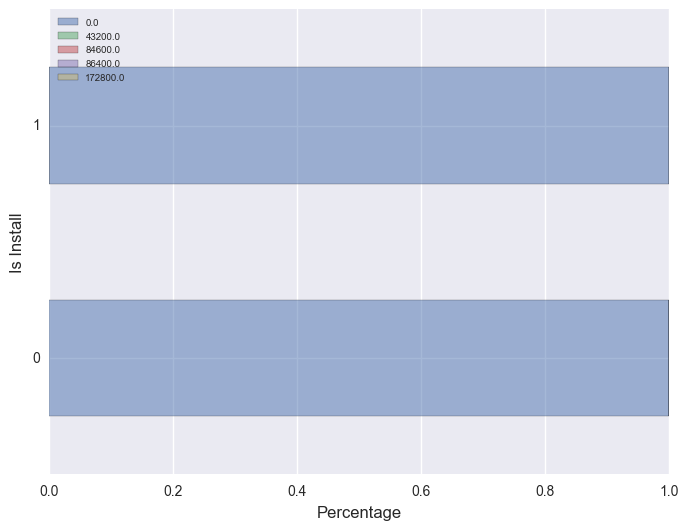

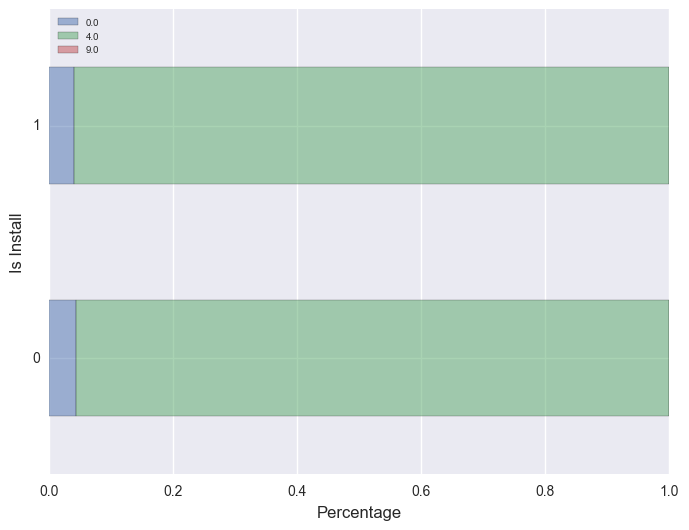

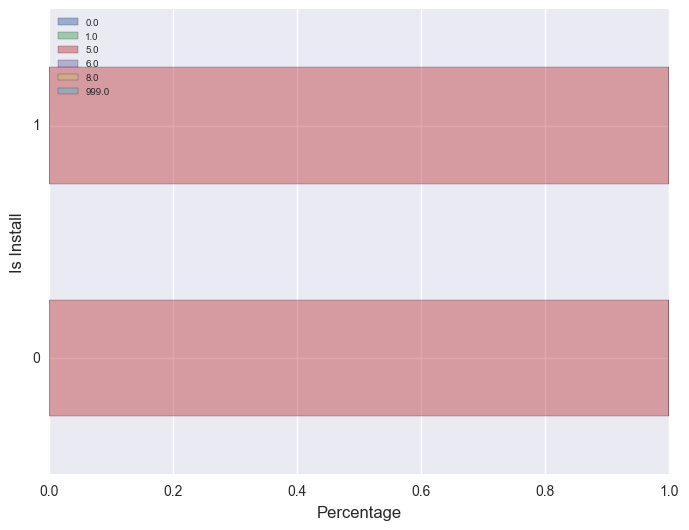

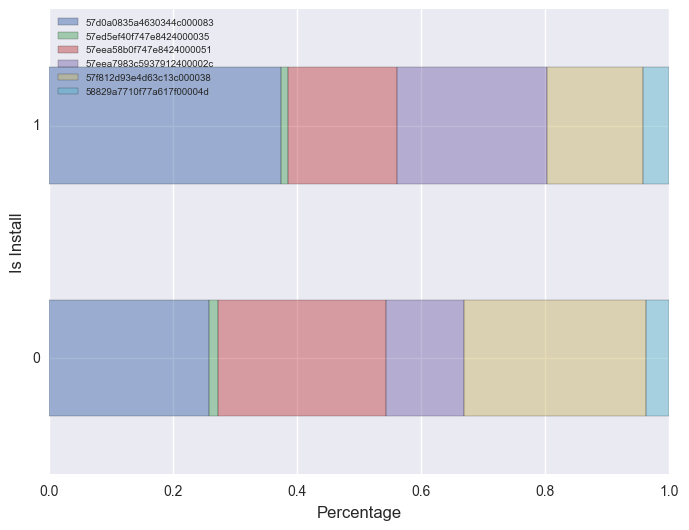

In [275]:
p_lst = []
for col in cat_cols:
    print '-----------Feature:', col,'----------------'
    p = categotical_EDA(col,df_mth_ad)
    p_lst.append(p)
    print '---------------------------------\n'

In [273]:
significant_cols = [col for col,p in zip(col_lst,)

[1.6696618217933362e-106,
 1.0,
 0.079215118523023598,
 0.99995812509161375,
 0.99999999857719757,
 0.99995420599186746,
 0.99999999999945566,
 0.99973291028096756]